In [21]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./Probs')

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from one_phase import m1, m2, m3

from one_phase import one_phase
from fix_bd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

test = wp.test_decorator(wp.test)
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# model to be studied
def model(u):
    return [u**2+1, 2*max(u, 0), 2]

In [23]:
class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

Несмотря на то, что в прошлом тесте не получилось превзойти метод Ньютона, попробуем улучшить результат засчет разбиения доменов

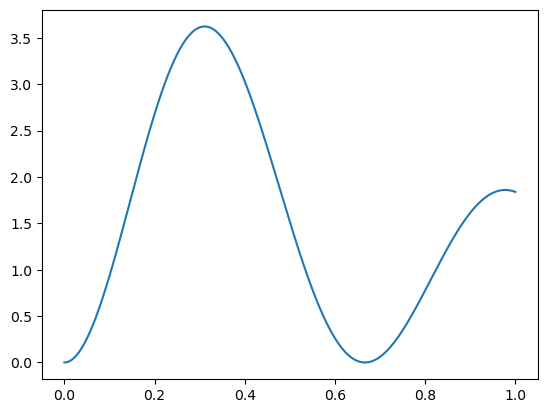

In [109]:
# we will take the same initial condition and grid parameters

Nx = 2000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
D = Diffusion(Nx, 0.9, 5, 0.2e-2, model=model)
x0 = 5*np.exp(-x)*np.sin(3*np.pi/2*x)**2
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]

plt.plot(x, x0)
plt.show()

In [112]:
prob = one_phase(D, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
solver_n.setSources([0.7], [-0.8])
nl_solver = newton(crit_abs=1e-8)
solver_n.setSolver(nl_solver)
solver_n.setInitial(x0)
X, mes, t, delta = test(solver_n, sample_size = 4)

test started
verdict : OK
time : 9.561 +- 0.5945
mean newton iterations:  4.1


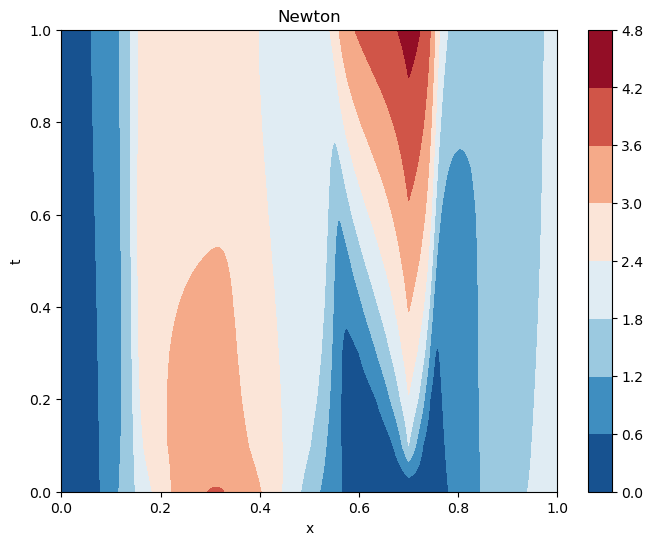

In [113]:
wp.show_res(solver_n)

### Построение доменов через разбиение графа
Две формулировки функции на минимизацию:
$$
    vol(\partial S_i) = \sum_{v \in V_i} \sum_{u \in \Gamma(v), u \notin V_i} {w(v, u)}
$$
Первый способ:$$
\sum \frac{vol(\partial S_i)}{| V_i|} \rightarrow \min
$$Второй способ:$$
\sum \frac{vol(\partial S_i)}{vol(V_i)} \rightarrow \min
$$где $vol(V_i) = \sum_{u, v \in V_i} w(u, v)$

In [114]:
results = {}

In [115]:
Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver_eq = fxbd_1D(param, prob)
solver_eq.setBoundary(bd1, bd2)
solver_eq.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-8, newton_crit_rel = 1e-5)
solver_eq.setSolver(nl_solver)
solver_eq.setInitial(x0)
X, mes, t_as, delta_as = test(solver_eq, sample_size = 4)
results['eq'] = t_as
results['delta, eq'] = delta_as

test started
verdict : OK
time : 21.32 +- 0.6051
mean aspen iterations:  4.7


--time comparision--
newton : 9.876013040542603
aspen : 20.8570659160614


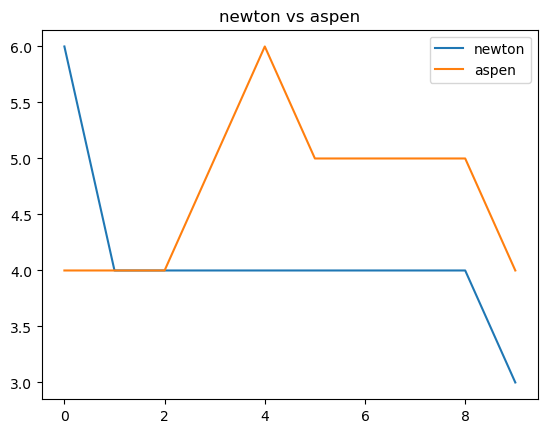

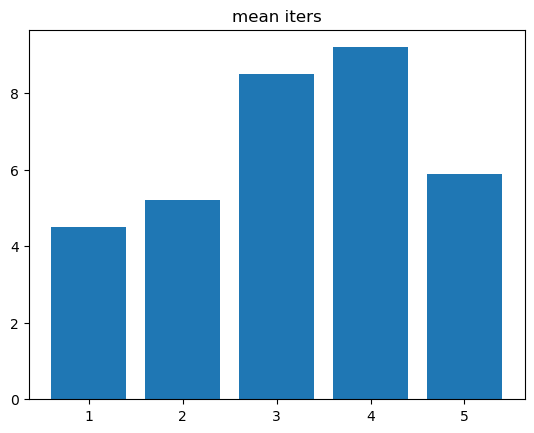

In [116]:
wp.compare([solver_n, solver_eq], ['newton', 'aspen'], save='comp, eq')
wp.bar_loc(solver_eq, Nd, save='bar, eq')

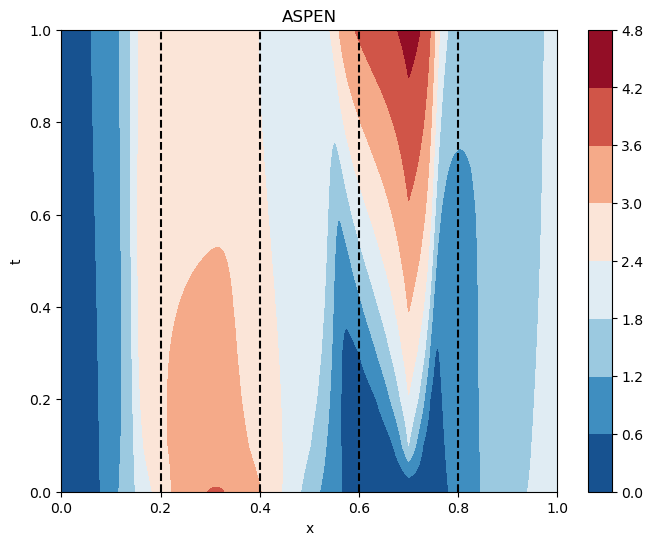

In [124]:
wp.show_res(solver_eq, save='eq_bad')

In [117]:
def border_changer(prob, X, nstep, Nd):
    Jf = prob.precompute_Jf(X[:, nstep], Nx, step = 20)
    #Jf = prob.precompute_Jf(X[:, nstep], Nx)
    func1 = lambda k, m: m1(Jf, k, m)
    A1 = pt.adj_matrix(func1, Nx//20)
    #A1 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A1, Nd,
        inv = False, k =Nd)
    borders = borders * 20
    print(borders)
    return borders

Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-8, newton_crit_rel = 1e-5)
solver.setSolver(nl_solver, bd_ch = border_changer)
solver.setInitial(x0)
X, mes, t_as, delta_as = test(solver, sample_size = 4, dyn_bd = True)
results['m1'] = t_as
results['delta, m1'] = delta_as

test started
[   0  300 1100 1500 1880 2000]
[   0  280 1100 1520 1880 2000]
[   0  280  700 1100 1540 2000]
[   0  280  700 1100 1560 2000]
[   0  300 1100 1500 1880 2000]
[   0  280 1100 1520 1880 2000]
[   0  280  700 1100 1540 2000]
[   0  280  700 1100 1560 2000]
[   0  300 1100 1500 1880 2000]
[   0  280 1100 1520 1880 2000]
[   0  280  700 1100 1540 2000]
[   0  280  700 1100 1560 2000]
[   0  300 1100 1500 1880 2000]
[   0  280 1100 1520 1880 2000]
[   0  280  700 1100 1540 2000]
[   0  280  700 1100 1560 2000]
verdict : OK
time : 20.69 +- 0.1944
mean aspen iterations:  4.5


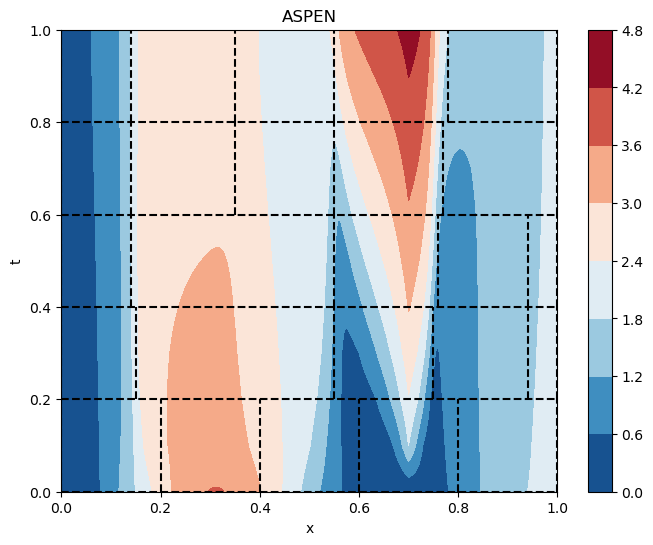

In [118]:
wp.show_res(solver, save='Diff0, m1')

--time comparision--
newton : 9.876013040542603
aspen : 20.716411590576172


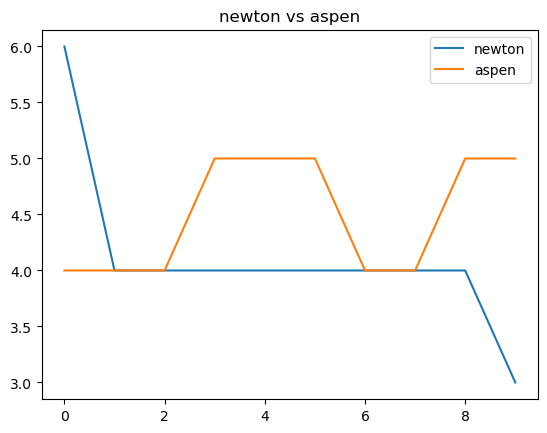

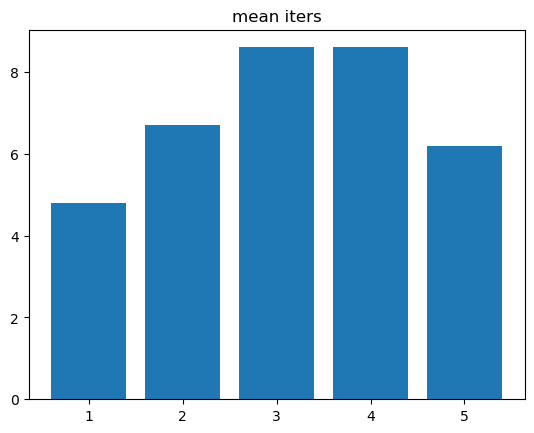

In [119]:
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp, m1')
wp.bar_loc(solver, Nd, save='bar, m1')

In [120]:
def border_changer(prob, X, nstep, Nd):
    func1 = lambda k, m: m2(X[:, :nstep+1], k, m, x_step = 20)
    #func1 = lambda k, m: m2(X, k, m)
    A2 = pt.adj_matrix(func1, Nx//20)
    #A2 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A2, Nd,
        inv = True, k =Nd)
    borders = borders * 20
    print(borders)
    return borders

Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-8, newton_crit_rel = 1e-5)
solver.setSolver(nl_solver, bd_ch = border_changer)
solver.setInitial(x0)
X, mes, t_as, delta_as = test(solver, sample_size = 4, dyn_bd = True)
results['m2'] = t_as
results['delta, m2'] = delta_as

test started
[   0  300  800 1180 1640 2000]
[   0  280  740 1220 1700 2000]
[   0  400  900 1240 1700 2000]
[   0  340  860 1280 1720 2000]
[   0  300  800 1180 1640 2000]
[   0  280  740 1220 1700 2000]
[   0  400  900 1240 1700 2000]
[   0  340  860 1280 1720 2000]
[   0  300  800 1180 1640 2000]
[   0  280  740 1220 1700 2000]
[   0  400  900 1240 1700 2000]
[   0  340  860 1280 1720 2000]
[   0  300  800 1180 1640 2000]
[   0  280  740 1220 1700 2000]
[   0  400  900 1240 1700 2000]
[   0  340  860 1280 1720 2000]
verdict : OK
time : 19.12 +- 0.5991
mean aspen iterations:  4.5


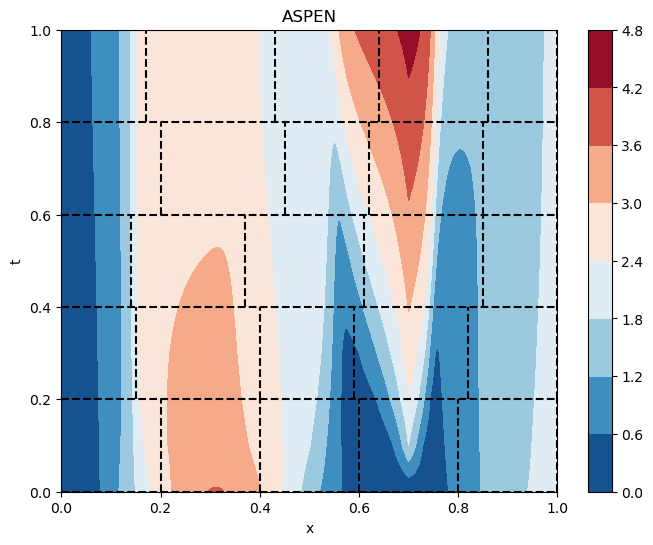

--time comparision--
newton : 9.876013040542603
aspen : 19.46211528778076


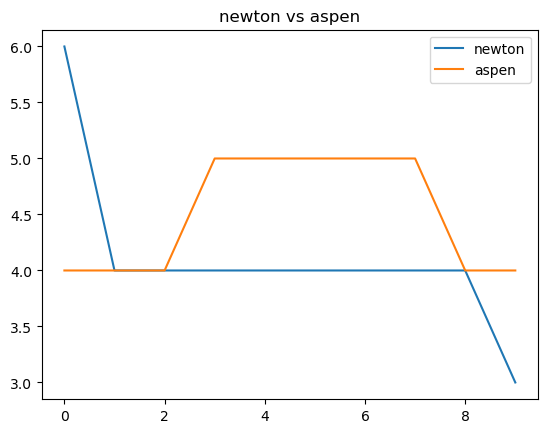

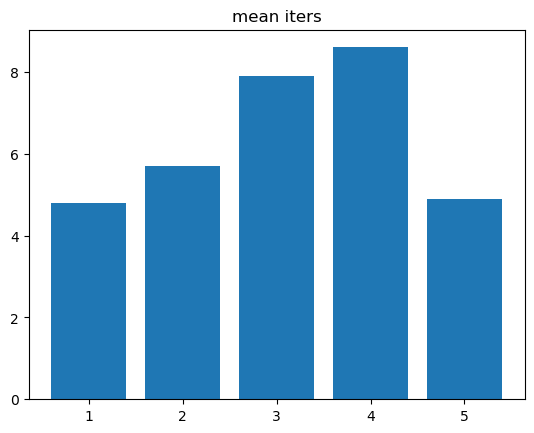

In [121]:
wp.show_res(solver, save='Diff0, m2')
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp, m2')
wp.bar_loc(solver, Nd, save='bar, m2')

In [122]:
def border_changer(prob, X, nstep, Nd):
    Jf = prob.precompute_Jf(X[:, nstep], Nx, step = 20)
    #Jf = prob.precompute_Jf(X[:, nstep], Nx)
    func1 = lambda k, m: m3(prob, X[:, nstep], Jf, k, m, 10, step = 20)
    #func1 = lambda k, m: m3(prob, X[:, nstep], Jf, k, m, 10)
    A3 = pt.adj_matrix(func1, Nx//20)
    #A3 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A3, Nd,
        inv = False, k =Nd)
    borders = borders * 20
    print(borders)
    return borders

Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-8, newton_crit_rel = 1e-5)
solver.setSolver(nl_solver, bd_ch = border_changer)
solver.setInitial(x0)
X, mes, t_as, delta_as = test(solver, sample_size = 4, dyn_bd=True)
results['m3'] = t_as
results['delta, m3'] = delta_as

test started
[   0  400  580  940 1680 2000]
[   0  420  600 1300 1700 2000]
[   0  420  840 1300 1680 2000]
[   0  420  860 1260 1660 2000]
[   0  400  580  940 1680 2000]
[   0  420  600 1300 1700 2000]
[   0  420  840 1300 1680 2000]
[   0  420  860 1260 1660 2000]
[   0  400  580  940 1680 2000]
[   0  420  600 1300 1700 2000]
[   0  420  840 1300 1680 2000]
[   0  420  860 1260 1660 2000]
[   0  400  580  940 1680 2000]
[   0  420  600 1300 1700 2000]
[   0  420  840 1300 1680 2000]
[   0  420  860 1260 1660 2000]
verdict : OK
time : 17.8 +- 0.282
mean aspen iterations:  4.1


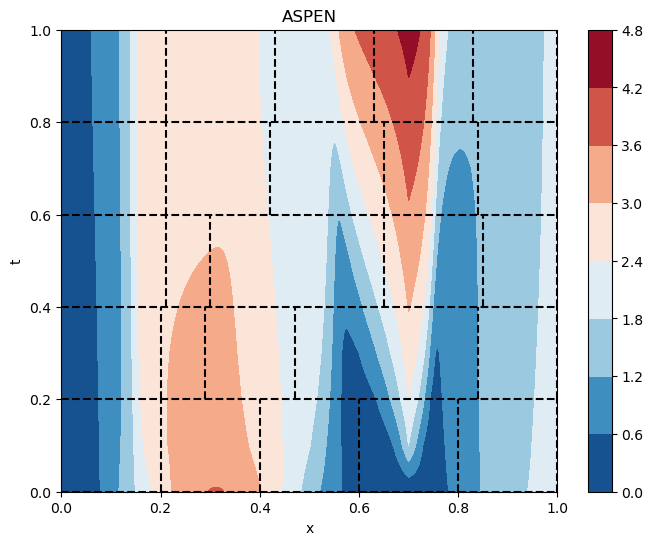

--time comparision--
newton : 9.876013040542603
aspen : 17.700060844421387


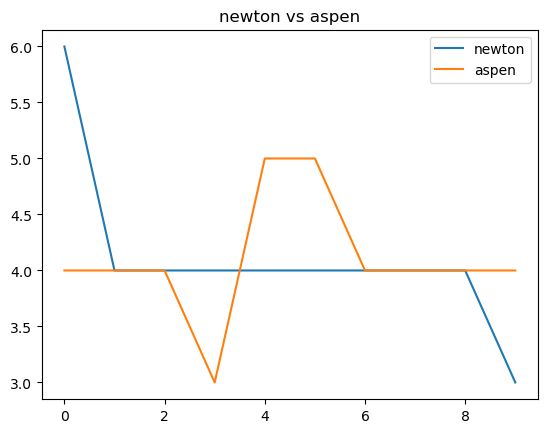

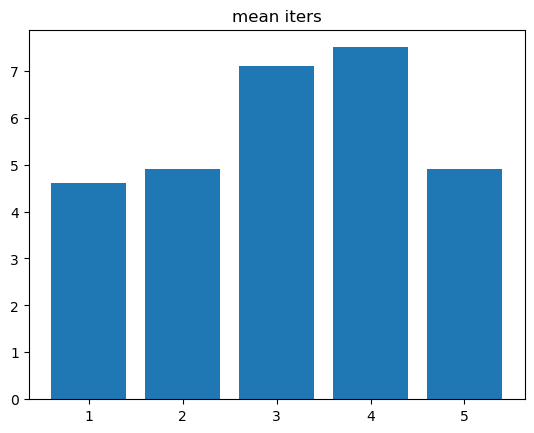

In [123]:
wp.show_res(solver, save='Diff0, m3')
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp, m3')
wp.bar_loc(solver, Nd, save='bar, m3')